<a href="https://colab.research.google.com/github/kstrickland680/DepressionSentimentalAnalysis/blob/main/DepressionTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Depression Sentiment Analysis

## Overview

This project analyzes twitter data that has been labeled according to whether it was written by a clinically depressed individual or not.  The project explores frequently used words, conducts a topic analysis, performs sentiment analysis, and creates a model to predict whether an individual is likely to be depressed based on their social media precense on Twitter. 

## Business Problem  

A nonprofit agency focused on mental health and depression wants a way to analyze Twitter data to assess for depression in individuals. Doing so can bolster prevention efforts to help individuals with depression.  

According to the Anxiety and Depression Association of America, Major Depressive Disorder (MDD) is the leading cause of disability for adults in the US aged 15-44. Over 16.1 million adults in America are affected by it each year.  Only 61% of adults with MDD receive treatment.  The US Department of Health & Human Services estimates that 60% of individuals who commit suicide had a mood disorder, such as MDD or bipolar.  

In [1]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 4.1MB/s 


In [2]:
import pandas as pd

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

import string

import re

from nltk.stem import WordNetLemmatizer

import tensorflow as tf

from gensim.models import Word2Vec

from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
from PIL import Image

from nltk.corpus import stopwords 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score

import requests
import bs4
from bs4 import BeautifulSoup
from requests_oauthlib import OAuth1
import tweepy

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')
#path = "drive/My Drive/DepressionTweets"


Mounted at /content/drive


## Data Understanding

The dataset consists of an index number, the tweet, and a classification as depressed/not depressed.  22.4% of the dataset is classified as written by a clinically depressed individual. 


In [6]:
df = pd.read_csv('/content/drive/My Drive/DepressionTweets/DepressionSentimentalAnalysis/data/sentiment_tweets3.csv')


In [7]:
df.head(20)

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,624,so sleepy. good times tonight though,0
6,701,"@SilkCharm re: #nbn as someone already said, d...",0
7,808,23 or 24ï¿½C possible today. Nice,0
8,1193,nite twitterville workout in the am -ciao,0
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0


In [8]:
df['label (depression result)'].value_counts(normalize = True)

0    0.775645
1    0.224355
Name: label (depression result), dtype: float64

In [9]:
df.shape

(10314, 3)

In [10]:
df.drop_duplicates(subset=['message to examine'])
df.shape

(10314, 3)

In [11]:
df.isna().any()

Index                        False
message to examine           False
label (depression result)    False
dtype: bool

## Data Preparation 

I create functions to help clean the text, including removing punctuation, URLs, stemming the text, and tokenizing it. 

In [12]:
def nopunct(tweet):
    new_words = [word for word in tweet if word.isalnum()]
    return new_words

In [13]:
def stemming(tweet):
  ps = PorterStemmer()
  stemmed = [ps.stem(word) for word in tweet]
  return stemmed



In [14]:
def clean_and_tokenize(data, message):
  #takes in a data frame and original tweet

  #remove URLS:
  data['tokenized'] = [' '.join(re.sub("http://\S+", " ", tweet).split()) for tweet in data[message]]
  data['tokenized'] = [' '.join(re.sub("myspace.com\S+", " ", tweet).split()) for tweet in data['tokenized']]
  data['tokenized'] = [' '.join(re.sub("https://\S+", " ", tweet).split()) for tweet in data['tokenized']]

  #remove numbers
  data['tokenized'] = [' '.join(re.sub(r'\d+', '', tweet).split()) for tweet in data['tokenized']]

  #remove hashtag
  data['tokenized'] = [' '.join(re.sub('#', "", tweet).split()) for tweet in data['tokenized']]

  #tweet tokenizer (lower clase, get rid of handles, reduce repeated letters)
  tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles = True, reduce_len=True)
  data['tokenized'] = [tweet_tokenizer.tokenize(entry) for entry in data['tokenized']]

  #stem the words
  data['tokenizedandstemmed'] = [stemming(tweet) for tweet in data['tokenized']]

  #remove punctuation
  data['tokenizedandstemmed'] = [nopunct(tweet) for tweet in data['tokenizedandstemmed']]

  return data


In [15]:
def sentiment_prep(data, message):
  #takes in dataframe and name of column with the tweet
  #prepares data for sentiment analysis.  It keeps punctuation, doesn't stem the words, and doesn't tokenize i
  

  #remove URLS:
  data['tokenized'] = [' '.join(re.sub("http://\S+", " ", tweet).split()) for tweet in data[message]]
  data['tokenized'] = [' '.join(re.sub("https://\S+", " ", tweet).split()) for tweet in data['tokenized']]
  data['tokenized'] = [' '.join(re.sub("myspace.com\S+", " ", tweet).split()) for tweet in data['tokenized']]

  #remove numbers
  data['tokenized'] = [' '.join(re.sub(r'\d+', '', tweet).split()) for tweet in data['tokenized']]

  #remove hashtag
  data['tokenized'] = [' '.join(re.sub('#', "", tweet).split()) for tweet in data['tokenized']]

  #remove mentions: 
  data['tokenized']=data['tokenized'].apply(lambda x :[t for t in x.split() if not t.startswith('@')]).apply(lambda x: ' '.join(x))

  data['tokenizedwithpunct'] = data['tokenized']
  #remove special characters and numbers
  data['tokenized'] = data['tokenized'].replace(r'[^A-Za-z]+', " ", regex=True)
  return data




## Depression Data

I create a dataframe of only the tweets from depressed indivduals to explore frequently used words and topics. I create a word cloud, which features words including depression, worthless, anti, anxiety, and functioning. 

In [16]:
df = clean_and_tokenize(df, 'message to examine')
df.head()

,Index,message to examine,label (depression result),tokenized,tokenizedandstemmed
0,106,just had a real good moment. i missssssssss hi...,0,"[just, had, a, real, good, moment, ., i, misss...","[just, had, a, real, good, moment, i, misss, h..."
1,217,is reading manga http://plurk.com/p/mzp1e,0,"[is, reading, manga]","[is, read, manga]"
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,[-],[]
3,288,@lapcat Need to send 'em to my accountant tomo...,0,"[need, to, send, ', em, to, my, accountant, to...","[need, to, send, em, to, my, account, tomorrow..."
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,"[add, me, on, myspace, !, !, !]","[add, me, on, myspac]"


<function matplotlib.pyplot.show>

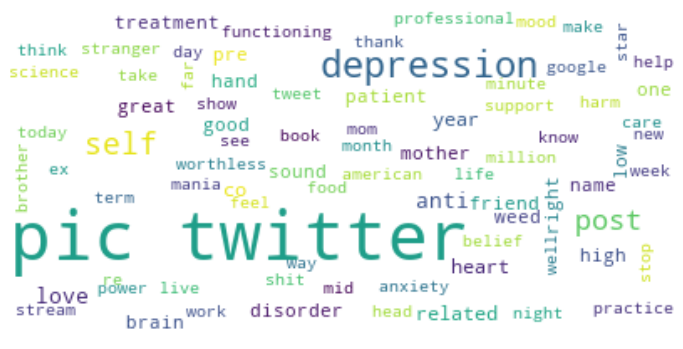

In [17]:

stop_words = stopwords.words('english')

dep = df[df['label (depression result)'] == 1]
dep.head()

depressed_corpus = [item for sublist in dep['tokenized'] for item in sublist]
filtered_depressed_corpus = [word for word in depressed_corpus if word not in stop_words]
unique_depressed_corpus = set(filtered_depressed_corpus)
unique_depressed_corpus = ' '.join(unique_depressed_corpus)
wordcloud = WordCloud(max_words=80, background_color="white").generate(unique_depressed_corpus)

#display the generated image:
plt.figure(figsize = (12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show

#wordcloud.to_file("img/depression.png")


### Depression Topic Modeling

I prepare the depression data for NMF topic modeling and then apply topic modeling over the tweets. Most tweets relate to the experience of depression (1741). Smaller topics included those with lots of emojis, talk about preventing depression, or things that were related to depression. 

In [18]:
#preparing depressed data for NMF Modeling 

#remove URLS:
dep['tokenized'] = [' '.join(re.sub("http://\S+", " ", tweet).split()) for tweet in dep['message to examine']]
dep['tokenized'] = [' '.join(re.sub("https://\S+", " ", tweet).split()) for tweet in dep['tokenized']]
dep['tokenized'] = [' '.join(re.sub("myspace.com\S+", " ", tweet).split()) for tweet in dep['tokenized']]

#remove numbers
dep['tokenized'] = [' '.join(re.sub(r'\d+', '', tweet).split()) for tweet in dep['tokenized']]

#remove mentions: 
dep['tokenized']=dep['tokenized'].apply(lambda x :[t for t in x.split() if not t.startswith('@')]).apply(lambda x: ' '.join(x))

dep['tokenizedwithpunct'] = dep['tokenized']

#remove special characters and numbers
dep['tokenized'] = dep['tokenized'].replace(r'[^A-Za-z]+', " ", regex=True)


dep.head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Index,message to examine,label (depression result),tokenized,tokenizedandstemmed,tokenizedwithpunct
8000,800000,The lack of this understanding is a small but ...,1,The lack of this understanding is a small but ...,"[the, lack, of, thi, understand, is, a, small,...",The lack of this understanding is a small but ...
8001,800001,i just told my parents about my depression and...,1,i just told my parents about my depression and...,"[i, just, told, my, parent, about, my, depress...",i just told my parents about my depression and...
8002,800002,depression is something i don't speak about ev...,1,depression is something i don t speak about ev...,"[depress, is, someth, i, speak, about, even, g...",depression is something i don't speak about ev...
8003,800003,Made myself a tortilla filled with pb&j. My de...,1,Made myself a tortilla filled with pb j My dep...,"[made, myself, a, tortilla, fill, with, pb, j,...",Made myself a tortilla filled with pb&j. My de...
8004,800004,@WorldofOutlaws I am gonna need depression med...,1,I am gonna need depression meds soon these rai...,"[i, am, gonna, need, depress, med, soon, these...","I am gonna need depression meds soon, these ra..."
8005,800005,my anxiety and my depression fighting over who...,1,my anxiety and my depression fighting over who...,"[my, anxieti, and, my, depress, fight, over, w...",my anxiety and my depression fighting over who...
8006,800006,wow she's suddenly cured my depression and gav...,1,wow she s suddenly cured my depression and gav...,"[wow, suddenli, cure, my, depress, and, gave, ...",wow she's suddenly cured my depression and gav...
8007,800007,"I am officially done with @kanyewest. him, the...",1,I am officially done with him the neptunes jus...,"[i, am, offici, done, with, him, the, neptun, ...","I am officially done with him, the neptunes, j..."
8008,800008,Me: what's wrong?My girl: *looks up at me with...,1,Me what s wrong My girl looks up at me with lo...,"[me, wrong, my, girl, look, up, at, me, with, ...",Me: what's wrong?My girl: *looks up at me with...
8009,800009,@AusBorderForce @PeterDutton_MP @shanebazzi Ag...,1,Agreed Emoji Clapping hands sign Emoji Clappin...,"[agre, emoji, clap, hand, sign, emoji, clap, h...",Agreed <Emoji: Clapping hands sign><Emoji: Cla...


In [19]:
## creating document term matrix

#removing stop words and twitter

stop = stopwords.words('english')
stop += 'twitter', 'com'

tfidf = TfidfVectorizer(max_df=0.95, stop_words=stop, ngram_range=(1,2))
dtm = tfidf.fit_transform(dep['tokenized'])


In [20]:
nmf_model = NMF(n_components=7, random_state=42)
topics = nmf_model.fit_transform(dtm)

In [21]:
for index, topic in enumerate(nmf_model.components_):
  print(f'The top 10 words for topic #{index}')
  print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])
  print('\n')

The top 10 words for topic #0
['emotional', 'development', 'mom depression', 'tied', 'intellectual', 'depression tied', 'intellectual development', 'kids emotional', 'tied kids', 'emotional intellectual']


The top 10 words for topic #1
['depression news', 'one us', 'anxiety', 'anxiety depression', 'us', 'children', 'teens', 'teens anxiety', 'children teens', 'us children']


The top 10 words for topic #2
['depression emoji', 'emoji face', 'face emoji', 'emoji loudly', 'loudly crying', 'loudly', 'crying', 'crying face', 'face', 'emoji']


The top 10 words for topic #3
['could one', 'cannabis ease', 'one', 'could', 'puff cannabis', 'ease', 'ease depression', 'one puff', 'puff', 'cannabis']


The top 10 words for topic #4
['feel', 'get', 'anxiety depression', 'mental', 'people', 'pic', 'know', 'like', 'depression anxiety', 'anxiety']


The top 10 words for topic #5
['study suggests', 'regularly', 'regularly cuts', 'depression study', 'exercising regularly', 'cuts', 'cuts risk', 'exercisi

In [22]:
dep['Topic'] = topics.argmax(axis=1)
naming={0: 'depression_ties', 1: 'news', 2: 'emoji', 3: 'cannabis', 4: 'depression_experience', 5: 'prevent_depression', 6: 'real'}
dep['topic_name']  = dep['Topic'].map(naming)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
pd.set_option('display.max_colwidth', None)
dep[['message to examine', 'topic_name']].head(10)

,message to examine,topic_name
8000,The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.,depression_experience
8001,i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy,depression_experience
8002,"depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.",depression_experience
8003,Made myself a tortilla filled with pb&j. My depression is cured. Olivia:1 depression:0,depression_experience
8004,"@WorldofOutlaws I am gonna need depression meds soon, these rainouts are spinning my equilibrium out <Emoji: Pouting face> Mother Nature is being a mean B-T-H <Emoji: Face with symbols over mouth>",emoji
8005,my anxiety and my depression fighting over whos day it is https://twitter.com/crissles/status/988218861697806336Â â¦,depression_experience
8006,wow she's suddenly cured my depression and gave us world peace https://twitter.com/bearfaceingtons/status/989289124883566593Â â¦,news
8007,"I am officially done with @kanyewest. him, the neptunes, justin timberlake, timbaland. got me out of depression when I was in younger. a lot of these artist have changed their sounds and I have still supported them, but this is too far",depression_experience
8008,Me: what's wrong?My girl: *looks up at me with look of depression and stress on her face**Me: same babe same. #examseason,emoji
8009,@AusBorderForce @PeterDutton_MP @shanebazzi Agreed <Emoji: Clapping hands sign><Emoji: Clapping hands sign><Emoji: Clapping hands sign>As someone with long experience of clinical depression I'd like to add this:Of course she fuckingwell yells and hits her head on the wall and says she wants to dieNobody can live forever without hopeShe won't get better while kept indefinitely on Nauru,emoji


In [23]:
dep['topic_name'].value_counts()

depression_experience    1741
emoji                     234
prevent_depression         97
depression_ties            83
real                       68
cannabis                   55
news                       36
Name: topic_name, dtype: int64

### Depression Sentiment Analysis

I use VADER sentiment analysis to compare the sentiments of tweets from clinically depressed individuals and non-depressed individuals. VADER is specifically tuned for social media language. 



In [24]:
analyzer = SentimentIntensityAnalyzer()

In [25]:
#run analyzer on tweets with punctuation, capitlizaton, and untokenized
#store scores in the dataframe as well as in sentscores variable 
scoress = []
for index, row in dep.iterrows():
  s = analyzer.polarity_scores(row['tokenizedwithpunct'])
  scoress.append(s)

sentscores = pd.Series(scoress)
dep['polarity'] = sentscores.values

dep.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Index,message to examine,label (depression result),tokenized,tokenizedandstemmed,tokenizedwithpunct,Topic,topic_name,polarity
8000,800000,The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.,1,The lack of this understanding is a small but significant part of what causes anxiety depression to both feel so incredibly lonely It s soooo easy to compare It s so easy to invalidate ourselves because of that,"[the, lack, of, thi, understand, is, a, small, but, signific, part, of, what, caus, anxieti, depress, to, both, feel, so, incred, lone, sooo, easi, to, compar, so, easi, to, invalid, ourselv, becaus, of, that]",The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.,4,depression_experience,"{'neg': 0.238, 'neu': 0.555, 'pos': 0.207, 'compound': -0.1767}"
8001,800001,i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy,1,i just told my parents about my depression and it s so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy,"[i, just, told, my, parent, about, my, depress, and, so, hard, to, get, gen, x, peopl, to, understand, that, thi, is, not, someth, that, i, can, control, all, the, time, or, just, cure, with, a, walk, or, by, keep, my, mind, busi]",i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy,4,depression_experience,"{'neg': 0.12, 'neu': 0.88, 'pos': 0.0, 'compound': -0.6774}"
8002,800002,"depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.",1,depression is something i don t speak about even going through it because it s also such a double edged sword i love every race even if white people had done so much i can t hate them all my grandma is legit white how tf can i hate i do dislike people though,"[depress, is, someth, i, speak, about, even, go, through, it, becaus, also, such, a, doubl, edg, sword, i, love, everi, race, even, if, white, peopl, had, done, so, much, i, hate, them, all, my, grandma, is, legit, white, how, tf, can, i, hate, i, do, dislik, peopl, though]","depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.",4,depression_experience,"{'neg': 0.162, 'neu': 0.725, 'pos': 0.113, 'compound': -0.4756}"
8003,800003,Made myself a tortilla filled with pb&j. My depression is cured. Olivia:1 depression:0,1,Made myself a tortilla filled with pb j My depression is cured Olivia depression,"[made, myself, a, tortilla, fill, with, pb, j, my, depress, is, cure, olivia, depress]",Made myself a tortilla filled with pb&j. My depression is cured. Olivia: depression:,4,depression_experience,"{'neg': 0.402, 'neu': 0.598, 'pos': 0.0, 'compound': -0.8126}"
8004,800004,"@WorldofOutlaws I am gonna need depression meds soon, these rainouts are spinning my equilibrium out <Emoji: Pouting face> Mother Nature is being a mean B-T-H <Emoji: Face with symbols over mouth>",1,I am gonna need depression meds soon these rainouts are spinning my equilibrium out Emoji Pouting face Mother Nature is being a mean B 

In [26]:
#compute the totals for the negative, neutral, and positive setiment expressed

neg, neu, pos = 0, 0, 0

for s in sentscores:
  neg += s['neg']
  neu += s['neu']
  pos += s['pos']

#turn them into percentages in order to compare with non-depressed data

neg_percent = neg/(neg+neu+pos) * 100
neu_percent = neu/(neg+neu+pos) * 100
pos_percent = pos/(neg+neu+pos) * 100


Text(0.5, 1.0, 'Sentiment analysis of depressed tweets')

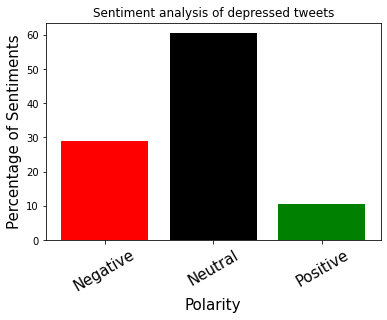

In [27]:
labels = ['Negative', 'Neutral', 'Positive']
index = np.arange(len(labels))
plt.bar(index,[neg_percent,neu_percent,pos_percent],color=['red','black','green'])
plt.ylabel('Percentage of Sentiments', fontsize=15)
plt.xlabel('Polarity', fontsize=15)
plt.xticks(index, labels, fontsize=15, rotation=30)
plt.title('Sentiment analysis of depressed tweets')

## Sentiment Analysis of Tweets from Non-Depressed Individuals 

I create a wordcloud from the tweets from non-depressed individuals. Frequently used words include love, lol, thank, and good. I then do VADER sentiment analysis to compare it with the sentiment analysis from tweets from clinically depressed individuals. 



<function matplotlib.pyplot.show>

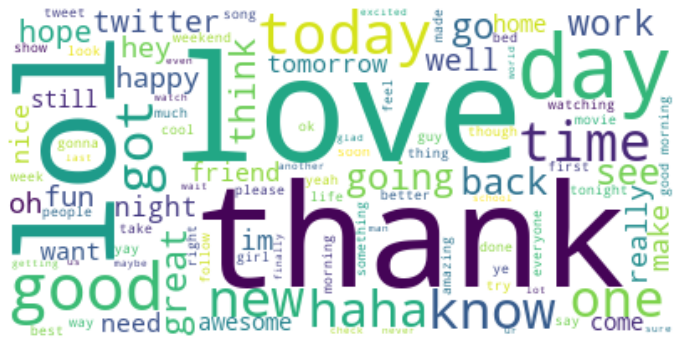

In [28]:
notdepressed = df[df['label (depression result)'] == 0]
notdepressed_corpus = [item for sublist in notdepressed['tokenized'] for item in sublist]
filtered_notdepressed_corpus = [word for word in notdepressed_corpus if word not in stop_words]
filtered_notdepressed_corpus = ' '.join(filtered_notdepressed_corpus)
wordcloud = WordCloud(max_words=100, background_color="white").generate(filtered_notdepressed_corpus)

#display the generated image:
plt.figure(figsize = (12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show

#wordcloud.to_file("img/notdepressed.png")

In [29]:
#prepare the data for VADER analysis 

notdepressed = sentiment_prep(notdepressed, 'message to examine')

notdepressed.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,Index,message to examine,label (depression result),tokenized,tokenizedandstemmed,tokenizedwithpunct
0,106,"just had a real good moment. i missssssssss him so much,",0,just had a real good moment i missssssssss him so much,"[just, had, a, real, good, moment, i, misss, him, so, much]","just had a real good moment. i missssssssss him so much,"
1,217,is reading manga http://plurk.com/p/mzp1e,0,is reading manga,"[is, read, manga]",is reading manga
2,220,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0,,[],-
3,288,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0,Need to send em to my accountant tomorrow Oddly I wasn t even referring to my taxes Those are supporting evidence though,"[need, to, send, em, to, my, account, tomorrow, oddli, i, even, refer, to, my, tax, those, are, support, evid, though]","Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though."
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,ADD ME ON MYSPACE,"[add, me, on, myspac]",ADD ME ON MYSPACE!!!
5,624,so sleepy. good times tonight though,0,so sleepy good times tonight though,"[so, sleepi, good, time, tonight, though]",so sleepy. good times tonight though
6,701,"@SilkCharm re: #nbn as someone already said, does fiber to the home mean we will all at least be regular now",0,re nbn as someone already said does fiber to the home mean we will all at least be regular now,"[re, nbn, as, someon, alreadi, said, doe, fiber, to, the, home, mean, we, will, all, at, least, be, regular, now]","re: nbn as someone already said, does fiber to the home mean we will all at least be regular now"
7,808,23 or 24ï¿½C possible today. Nice,0,or C possible today Nice,"[or, ï, ½c, possibl, today, nice]",or ï¿½C possible today. Nice
8,1193,nite twitterville workout in the am -ciao,0,nite twitterville workout in the am ciao,"[nite, twittervil, workout, in, the, am, ciao]",nite twitterville workout in the am -ciao
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0,Night darlin Sweet dreams to you,"[night, darlin, sweet, dream, to, you]","Night, darlin'! Sweet dreams to you"


In [30]:
#run analyzer on tweets with punctuation, capitlizaton, and untokenized
#store scores in the dataframe as well as in ndsentscores variable 

ndanalyzer = SentimentIntensityAnalyzer()

ndscoress = []
for index, row in notdepressed.iterrows():
  nds = ndanalyzer.polarity_scores(row['tokenizedwithpunct'])
  ndscoress.append(nds)

ndsentscores = pd.Series(ndscoress)
notdepressed['polarity'] = ndsentscores.values

notdepressed.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Index,message to examine,label (depression result),tokenized,tokenizedandstemmed,tokenizedwithpunct,polarity
0,106,"just had a real good moment. i missssssssss him so much,",0,just had a real good moment i missssssssss him so much,"[just, had, a, real, good, moment, i, misss, him, so, much]","just had a real good moment. i missssssssss him so much,","{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}"
1,217,is reading manga http://plurk.com/p/mzp1e,0,is reading manga,"[is, read, manga]",is reading manga,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,220,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0,,[],-,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
3,288,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0,Need to send em to my accountant tomorrow Oddly I wasn t even referring to my taxes Those are supporting evidence though,"[need, to, send, em, to, my, account, tomorrow, oddli, i, even, refer, to, my, tax, those, are, support, evid, though]","Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.","{'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'compound': 0.4404}"
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,ADD ME ON MYSPACE,"[add, me, on, myspac]",ADD ME ON MYSPACE!!!,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
5,624,so sleepy. good times tonight though,0,so sleepy good times tonight though,"[so, sleepi, good, time, tonight, though]",so sleepy. good times tonight though,"{'neg': 0.0, 'neu': 0.611, 'pos': 0.389, 'compound': 0.4902}"
6,701,"@SilkCharm re: #nbn as someone already said, does fiber to the home mean we will all at least be regular now",0,re nbn as someone already said does fiber to the home mean we will all at least be regular now,"[re, nbn, as, someon, alreadi, said, doe, fiber, to, the, home, mean, we, will, all, at, least, be, regular, now]","re: nbn as someone already said, does fiber to the home mean we will all at least be regular now","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
7,808,23 or 24ï¿½C possible today. Nice,0,or C possible today Nice,"[or, ï, ½c, possibl, today, nice]",or ï¿½C possible today. Nice,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.4215}"
8,1193,nite twitterville workout in the am -ciao,0,nite twitterville workout in the am ciao,"[nite, twittervil, workout, in, the, am, ciao]",nite twitterville workout in the am -ciao,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0,Night darlin Sweet dreams to you,"[night, darlin, sweet, dream, to, you]","Night, darlin'! Sweet dreams to you","{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.7177}"


In [31]:
#compute the totals for the negative, neutral, and positive setiment expressed

ndneg, ndneu, ndpos = 0, 0, 0

for nds in ndsentscores:
  ndneg += nds['neg']
  ndneu += nds['neu']
  ndpos += nds['pos']

#turn them into percentages so it's easily compariable 

ndneg_percent = ndneg/(ndneg+ndneu+ndpos) * 100
ndneu_percent = ndneu/(ndneg+ndneu+ndpos) * 100
ndpos_percent = ndpos/(ndneg+ndneu+ndpos) * 100


Text(0.5, 1.0, 'Sentiment analysis of not-depressed tweets')

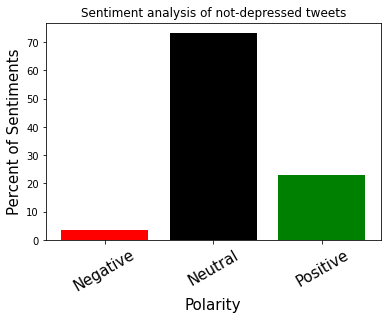

In [32]:
labels = ['Negative', 'Neutral', 'Positive']
index = np.arange(len(labels))
plt.bar(index,[ndneg_percent,ndneu_percent,ndpos_percent],color=['red','black','green'])
plt.ylabel('Percent of Sentiments', fontsize=15)
plt.xlabel('Polarity', fontsize=15)
plt.xticks(index, labels, fontsize=15, rotation=30)
plt.title('Sentiment analysis of not-depressed tweets')


## Comparison of Sentiment Analysis

Clinically depressed indviduals posted more negative tweets, less positive tweets, and slightly less neutral tweets than non-depressed individuals. 

Text(0.5, 1.0, 'Sentiment Analysis of  Tweets')

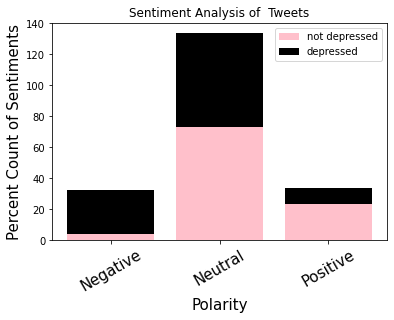

In [33]:
labels = ['Negative', 'Neutral', 'Positive']
index = np.arange(len(labels))
plt.bar(index,[ndneg_percent,ndneu_percent,ndpos_percent],color='pink')
plt.bar(index,[neg_percent,neu_percent,pos_percent],bottom = [ndneg_percent,ndneu_percent,ndpos_percent], 
        color='black')
plt.ylabel('Percent Count of Sentiments', fontsize=15)
plt.xlabel('Polarity', fontsize=15)
plt.xticks(index, labels, fontsize=15, rotation=30)
plt.legend(["not depressed", "depressed"])
plt.title('Sentiment Analysis of  Tweets')

## Modeling

I split the data into train and test sets, map each word in the training set to a number, apply that mapping to the data, and create a LSTM model. 

In [34]:
#train test split
X = df['tokenizedandstemmed']
Y = df['label (depression result)']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)

#train test split, before modeling, afer whatever steps I need to do; make the maps on the traning data
#make mapping based on training data; set some encoding to be like if I see a new word, how to handle it 


In [35]:
def check_encoding(word, token_map):
  #this function takes in a word and a set. If the word is in the set, it returns the encoding
  #if the word is not, it returns 0 
  if word in token_map:
    return token_map.get(word)
  else: 
    return 0

In [36]:
##convert words to indices.  I create a set, and add every word in the training data to it. 
word_set = set()
for sent in X_train:
  word_set.update(sent)

#I create a dictionary mapping each word to a number representing it 
#enumerate returns 2 variables, the count and the value of the item at that iteration 
token_map = {word: i+1 for i, word in enumerate(word_set)} #offset by 1 to allow for padding value
token_map['<#PAD>'] = 0

#create our sentences
X_train_indices = [[token_map[word] for word in sent] for sent in X_train ]

#use the encoding on the test data
X_test_indices = [[check_encoding(word, token_map) for word in sent] for sent in X_test]

#dealing with sentences being dfferent lengths
X_train_indices = tf.keras.preprocessing.sequence.pad_sequences(X_train_indices, padding='post').tolist()
X_test_indices = tf.keras.preprocessing.sequence.pad_sequences(X_test_indices, padding = 'post').tolist()

In [37]:
#building a LSTM model. Creating an embeddg layer with indices to vectors

dim = 256
hid_dim = 64

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(word_set)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hid_dim, return_sequences=False), 
                                    tf.keras.layers.Dense(2), # 2 is the number of labels you want to pick from
                                    tf.keras.layers.Softmax() 
])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2608896   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                82176     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0         
Total params: 2,691,202
Trainable params: 2,691,202
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Compile the model 
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 


X_train_ind_padded = np.array(X_train_indices)
X_test_ind_padded = np.array(X_test_indices)                          

history = model.fit(X_train_ind_padded, Y_train, epochs=2, batch_size=64)

Epoch 1/2
129/129 [==============================] - 38s 48ms/step - loss: 0.3854 - accuracy: 0.8545
Epoch 2/2
129/129 [==============================] - 6s 46ms/step - loss: 0.0138 - accuracy: 0.9976


### Model Analysis 

The model has high accuracy, precsion, recall, and f1 scores for test data.  There is not a large difference beween test and train data for accuracy.  

In [39]:
score = model.evaluate(X_test_ind_padded, Y_test, verbose = 1)
score_train = model.evaluate(X_train_ind_padded, Y_train, verbose = 1)

print()
print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

#from sklearn.metrics import f1_score, precision_score, recall_score
y_pred1 = model.predict(X_test_ind_padded)
y_pred = np.argmax(y_pred1, axis=1)

print()
print('Precision Score')
print(precision_score(Y_test, y_pred, average='macro'))
print()
print('Recall Score')
print(recall_score(Y_test, y_pred, average='macro'))
print()
print('F1 Score')
print(f1_score(Y_test, y_pred, average='macro'))


258/258 [==============================] - 2s 4ms/step - loss: 0.0064 - accuracy: 0.9990

Evaluate on test data
Test loss: 0.03718341886997223 / Test accuracy: 0.9941832423210144
Evaluate on train data
Train loss: 0.006360184401273727 / Train accuracy: 0.9990304112434387

Precision Score
0.9922413172525306

Recall Score
0.9906559530610499

F1 Score
0.9914459862892526


## New Data

I now import data from Twitter to test the model against. I import the most recent 400 tweets each for #depression, #depressed, depression, and depressed. I also import 500 random tweets that do not mention depression. 

I select a random amount of the tweets to look at, and look at the totals for those classified as depressed or not depressed.  The model classifies most data with the word 'depressed' or 'depression' in it as from a clinically depressed individual. It struggles to recognize informational or positive posts as well as exaggeration. 

In [40]:
import sys
sys.path.append('/content/drive/MyDrive/DepressionTweets/DepressionSentimentalAnalysis')
import config2

#config 2 has my passwords/keys 

In [41]:
#get authorization from Twitter and create my API to gather data

auth_params = {
    'app_key': config2.api_key,
    'app_secret': config2.api_secret,
    'bearer_token': config2.bearer_token,
    'access_token': config2.access_token,
    'access_token_secret': config2.access_token_secret
}

auth = tweepy.OAuthHandler(auth_params['app_key'], auth_params['app_secret'])
auth.set_access_token(auth_params['access_token'], auth_params['access_token_secret'])

api = tweepy.API(auth, wait_on_rate_limit=True)


In [63]:
#extract tweets 
hashtag_depressed_tweets = tweepy.Cursor(api.search, q="#depressed" + " -filter:retweets", lang='en', tweet_mode='extended').items(200)
depressed_tweets = tweepy.Cursor(api.search, q="depressed" + " -filter:retweets", lang='en', tweet_mode='extended').items(200)
hashtag_depression_tweets = tweepy.Cursor(api.search, q="#depression" + " -filter:retweets", lang='en', tweet_mode='extended').items(200)
depression_tweets = tweepy.Cursor(api.search, q="depression" + " -filter:retweets", lang='en', tweet_mode='extended').items(200)
random_tweets = tweepy.Cursor(api.search, q="-depressed" + '-depression' + '-#depressed' + '-#depression' + " -filter:retweets", lang='en', tweet_mode='extended').items(200)


In [64]:
#each set gets made into it's own dataframe 
hdepressed = pd.DataFrame(data=[tweet.full_text for tweet in hashtag_depressed_tweets], columns=['message'])

In [65]:
depressed = pd.DataFrame(data=[tweet.full_text for tweet in depressed_tweets], columns=['message'])

In [66]:
hdepression = pd.DataFrame(data=[tweet.full_text for tweet in hashtag_depression_tweets], columns=['message'])

In [67]:
depression = pd.DataFrame(data=[tweet.full_text for tweet in depression_tweets], columns=['message'])


In [68]:
random = pd.DataFrame(data=[tweet.full_text for tweet in random_tweets], columns=['message'])

In [69]:
#clean  the data for the model 

hdepressed_tokenized = clean_and_tokenize(hdepressed, 'message')
depressed_tokenized = clean_and_tokenize(depressed, 'message')
hdepression_tokenized = clean_and_tokenize(hdepression, 'message')
depression_tokenized = clean_and_tokenize(depression, 'message')
random_tokenized = clean_and_tokenize(random, 'message')

#add a column with the query term, and then combine the dataframes into 1

hdepressed_tokenized['query'] = 'hashtagdepressed'
depressed_tokenized['query'] = 'depressed'
hdepression_tokenized['query'] = 'hashtagdepression'
depression_tokenized['query'] = 'depression'
random_tokenized['query'] = 'random'


dataframes = [hdepressed_tokenized, depressed_tokenized, hdepression_tokenized,
              depression_tokenized, random_tokenized]
new_data = pd.concat(dataframes)

new_data.tail(10)

,message,tokenized,tokenizedandstemmed,query
190,"@blubserror ""BROTHERLY?"" \n-georgenotfound himself","["", brotherly, ?, "", -, georgenotfound, himself]","[brotherli, georgenotfound, himself]",random
191,This cretin thinks people dying of cancer is funny. https://t.co/NgFgGv0LMs,"[this, cretin, thinks, people, dying, of, cancer, is, funny, .]","[thi, cretin, think, peopl, die, of, cancer, is, funni]",random
192,"The Lesser Stag Beetle is one of our key species to look for with our new identification guide and survey booklet. To get your free copy, check out our blog https://t.co/gqtOd4rPu8 https://t.co/wR5Q9ljObC","[the, lesser, stag, beetle, is, one, of, our, key, species, to, look, for, with, our, new, identification, guide, and, survey, booklet, ., to, get, your, free, copy, ,, check, out, our, blog]","[the, lesser, stag, beetl, is, one, of, our, key, speci, to, look, for, with, our, new, identif, guid, and, survey, booklet, to, get, your, free, copi, check, out, our, blog]",random
193,"Oh, well... Study time.","[oh, ,, well, ..., study, time, .]","[oh, well, studi, time]",random
194,"@peterrhague Its like Amazon, the business is growing as fast as it can make money and in some sections faster than it can. . \n\nThat said, its stock price *is* ridiculous.","[its, like, amazon, ,, the, business, is, growing, as, fast, as, it, can, make, money, and, in, some, sections, faster, than, it, can, . ., that, said, ,, its, stock, price, *, is, *, ridiculous, .]","[it, like, amazon, the, busi, is, grow, as, fast, as, it, can, make, money, and, in, some, section, faster, than, it, can, that, said, it, stock, price, is, ridicul]",random
195,@RahulGandhi Okay.. Is this also part of toolkit???\n\n#CongressToolkitExposed,"[okay, .., is, this, also, part, of, toolkit, ?, ?, ?, congresstoolkitexposed]","[okay, is, thi, also, part, of, toolkit, congresstoolkitexpos]",random
196,@Fer_Caso Son homosexuales .,"[son, homosexuales, .]","[son, homosexual]",random
197,"@SootJack I just want to piss and shid in your bed, is that too much to ask?","[i, just, want, to, piss, and, shid, in, your, bed, ,, is, that, too, much, to, ask, ?]","[i, just, want, to, piss, and, shid, in, your, bed, is, that, too, much, to, ask]",random
198,Wait so if the 81 million voters for Resident Xiden are the majority of this country. Why is it only 36% of the country are vaccinated ? I though they all believed in science ?,"[wait, so, if, the, million, voters, for, resident, xiden, are, the, majority, of, this, country, ., why, is, it, only, %, of, the, country, are, vaccinated, ?, i, though, they, all, believed, in, science, ?]","[wait, so, if, the, million, voter, for, resid, xiden, are, the, major, of, thi, countri, whi, is, it, onli, of, the, countri, are, vaccin, i, though, they, all, believ, in, scienc]",random
199,Oh please believe I'll be a gentleman \nOr you can show me the door,"[oh, please, believe, i'll, be, a, gentleman, or, you, can, show, me, the, door]","[oh, pleas, believ, be, a, gentleman, or, you, can, show, me, the, door]",random


In [70]:
newdata_indices = [[check_encoding(word, token_map) for word in sent] for sent in new_data['tokenizedandstemmed']]
newdata_indices = tf.keras.preprocessing.sequence.pad_sequences(newdata_indices, padding = 'post').tolist()



In [71]:
new = model.predict_classes(newdata_indices)
new_data.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(1000, 4)

In [72]:
#check prediction against actual tweet for randomized set 
new_data['prediction'] = new

In [73]:
new_data['prediction'].value_counts()

1    810
0    190
Name: prediction, dtype: int64

In [74]:
randomsample = new_data.sample(n=50)
randomsample.head(20)

,message,tokenized,tokenizedandstemmed,query,prediction
193,"Oh, well... Study time.","[oh, ,, well, ..., study, time, .]","[oh, well, studi, time]",random,0
59,you are so precious &lt;3. also don't rub ur flirting in my face 🥰🗡️,"[you, are, so, precious, <, ., also, don't, rub, ur, flirting, in, my, face, 🥰, 🗡, ️]","[you, are, so, preciou, also, rub, ur, flirt, in, my, face]",random,0
98,Depressed 😠 https://t.co/sRY68KyW00,"[depressed, 😠]",[depress],depressed,1
153,I'm failing once again! Feeling like I don't need to be here. #depression #MentalHealthAwarenessWeek #mentalhealth #suicidal #thoughts 😭 https://t.co/jWGRdXgPoP,"[i'm, failing, once, again, !, feeling, like, i, don't, need, to, be, here, ., depression, mentalhealthawarenessweek, mentalhealth, suicidal, thoughts, 😭]","[fail, onc, again, feel, like, i, need, to, be, here, depress, mentalhealthawarenessweek, mentalhealth, suicid, thought]",hashtagdepression,1
72,"⠀\n⠀\n𝗡𝗦𝗙𝗪 content that 𝗺𝗮𝘆 contain:\n\n➻ abuse (physical, sexual, verbal, psychological)\n➻ blood, kidnapping, violence\n➻ overdose (alcohol, drug)\n➻ bullying, depression\n➻ etc\n\n⠀","[⠀, ⠀, 𝗡𝗦𝗙𝗪, content, that, 𝗺𝗮𝘆, contain, :, ➻, abuse, (, physical, ,, sexual, ,, verbal, ,, psychological, ), ➻, blood, ,, kidnapping, ,, violence, ➻, overdose, (, alcohol, ,, drug, ), ➻, bullying, ,, depression, ➻, etc, ⠀]","[𝗡𝗦𝗙𝗪, content, that, 𝗺𝗮𝘆, contain, abus, physic, sexual, verbal, psycholog, blood, kidnap, violenc, overdos, alcohol, drug, bulli, depress, etc]",depression,1
171,2 I’m voting for @BTS_twt for #BBMAsTopSocial,"[i, ’, m, voting, for, for, bbmastopsocial]","[i, m, vote, for, for, bbmastopsoci]",random,0
27,Anyone ever realise that the people who say to talk and not keep things to yourself are actually never there when you actually need to talk or make you feel like you shouldn’t talk to them? No? Just me then 🙄 #depression #depressed #depressionsupport #depressionhelp,"[anyone, ever, realise, that, the, people, who, say, to, talk, and, not, keep, things, to, yourself, are, actually, never, there, when, you, actually, need, to, talk, or, make, you, feel, like, you, shouldn, ’, t, talk, to, them, ?, no, ?, just, me, then, 🙄, depression, depressed, depressionsupport, depressionhelp]","[anyon, ever, realis, that, the, peopl, who, say, to, talk, and, not, keep, thing, to, yourself, are, actual, never, there, when, you, actual, need, to, talk, or, make, you, feel, like, you, shouldn, t, talk, to, them, no, just, me, then, depress, depress, depressionsupport, depressionhelp]",hashtagdepressed,1
31,No idea during the summer? Im sure im the most depressed person 🐝,"[no, idea, during, the, summer, ?, im, sure, im, the, most, depressed, person, 🐝]","[no, idea, dure, the, summer, im, sure, im, the, most, depress, person]",depressed,1
106,Bc spoilers//\n\nWHY DOES HE LOOKS SO DEPRESSED https://t.co/WMENkyjA1p,"[bc, spoilers, /, /, why, does, he, looks, so, depressed]","[bc, spoiler, whi, doe, he, look, so, depress]",depressed,1
106,"depression and shitty overall mental health SUX, help meeeee","[depression, and, shitty, overall, mental, health, sux, ,, help, meee]","[depress, and, shitti, overal, mental, health, sux, help, meee]",depression,1


# Conclusions

Analyzing social media data could help identify individuals who are unable or not willing to talk to professionals about their emotions. Many individuals share their emotions on social media regarding depression.  

## Business Recommendations

*   Pay attention to tweets that talk about feeling depressed -- People who say they're feeling depressed likely are.  
*   Increase social media presence.  Make informational or postive posts about depression.  
*   Pay attention to tweets talking about feeling worthless or hurting. 
*   Use how individuals talk about their experiences on social media to inform how you talk to people about depression. 






Future Work: 

- create a model that codes tweets for depression criteria
- a model that does better at seeing the difference between informational tweets about depression and depressed tweets - perhaps by classifying tweets 3 ways, depressed, not depressed, information about depression.  Another method with the current dataset would be to scramble the sentences from the depressed set, and label those scrambled versions as "not enough information." 
- possibly creating a bot that could reach out to individuals seen as at-risk of depression 
- a model that flags suicidal comments or classifies risk 